In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle
import data.datautil as du

from models import TransformerEncoder, TransformerDecoder, StateTransition

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
data_name='Rectifier_oct23_cap'
sim_name='RectifierData_step10h' 
dataset_name='RUL_real_cap'

In [4]:
with open(f'./data/{data_name}/dataset_{dataset_name}_train.pkl', 'rb') as file:
    train_dataset = pickle.load(file)
    
batch_size = 64
stats = ['X']
timestep=9
window={'X':[timestep,0],'Y':[0,0]}
trainloader = du.create_loader(train_dataset, batch_size, stats, window=window, shuffle=False) # for now, don't shuffle
trainloader

In [5]:
with open(f'./data/{data_name}/dataset_{dataset_name}_test.pkl', 'rb') as file:
    test_dataset = pickle.load(file)
    
batch_size = 128
stats = ['X']
timestep=9
window={'X':[timestep,0],'Y':[0,0]}
testloader = du.create_loader(test_dataset, batch_size, stats, window=window, shuffle=False)
testloader

In [6]:
ex_X, ex_y = next(iter(trainloader))
print(f"X Shape: {ex_X.shape}, Y Shape: {ex_y.shape}")

X Shape: torch.Size([64, 10, 7]), Y Shape: torch.Size([64, 1, 1])


In [7]:
dim = 3

enc = TransformerEncoder(input_dim=ex_X.shape[2], embed_dim=dim).to(device)
checkpoint = torch.load(f'./saved_models/const_enc_{dim}dim.pth')
print(checkpoint.keys())
enc.load_state_dict(checkpoint['model_state_dict'], strict=False)
enc.positional_embed.data = checkpoint['positional_embed']
for param in enc.parameters():
    param.requires_grad = False

dec = TransformerDecoder(output_dim=ex_X.shape[2], embed_dim=dim).to(device)
dec.load_state_dict(torch.load(f'./saved_models/const_dec_{dim}dim.pth'))
for param in dec.parameters():
    param.requires_grad = False

dict_keys(['model_state_dict', 'positional_embed'])


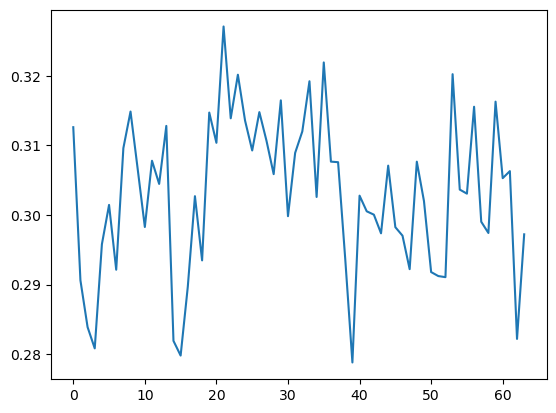

In [8]:
plt.plot(ex_X[:,-1,0])

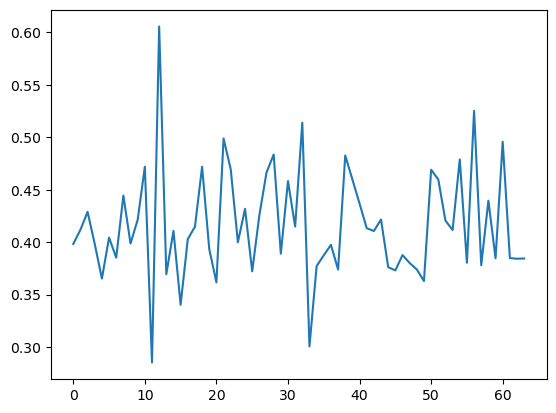

In [9]:
plt.plot(dec(enc(ex_X.to(torch.float32).to(device))).cpu().numpy()[:,0])

In [10]:
ex_z = enc(ex_X.to(torch.float32).to(device))

In [11]:
transition = StateTransition(dim, hidden_dim=64).to(device)
transition(ex_z, 1)

tensor([[-1.6506, -2.0743, -0.4358],
        [-1.6337, -3.2057, -1.1797],
        [-2.1240, -2.4614, -0.1126],
        [-2.2193, -2.8774, -0.1503],
        [-1.5433, -2.0327, -0.4108],
        [-1.2531, -1.5524, -0.5584],
        [-0.8420, -3.1623, -1.8660],
        [-1.7518, -2.1645,  0.1893],
        [-1.7475, -2.1748, -0.6415],
        [-0.4152, -1.4812, -1.0419],
        [-0.5969, -1.9350, -0.9405],
        [-1.1864, -2.3958, -0.2197],
        [-2.1770, -2.0783, -0.5293],
        [-1.7077, -3.0328, -1.3113],
        [-0.8088, -1.4901, -0.9454],
        [-0.9349, -1.9785, -1.4317],
        [-2.3453, -2.9493, -0.2335],
        [-1.4813, -2.2234, -0.6841],
        [-2.3534, -2.3500, -0.1478],
        [-1.6264, -2.6406, -0.3158],
        [-1.7275, -2.5532, -1.8043],
        [-1.3764, -3.2034, -0.4629],
        [-1.9583, -1.5875,  0.2195],
        [-1.8507, -2.1617, -1.1249],
        [-1.0372, -2.2074, -0.6888],
        [-1.7011, -2.6237,  0.3250],
        [-2.4287, -2.5991, -1.4894],
 

In [12]:
objective = nn.MSELoss()
transition = StateTransition(dim, hidden_dim=256).to(device)
params = transition.parameters()
optim = torch.optim.Adam(params, lr=1e-3)
losses = []

n_epochs = 10

for epoch_num in tqdm(range(n_epochs)):
    done = False
    for i, (X, y) in enumerate(trainloader):
        if i > 1:
            done = False
            
        if not done:
            optim.zero_grad()
            X = X.to(torch.float32).to(device)
            n_steps = int(np.random.uniform(1, 10))
            while (i) * trainloader.batch_size + X.shape[0] + n_steps > len(trainloader.dataset): # if we go beyond length of the dataset
                n_steps -= 1
                
            valid_steps = y > n_steps # make sure this is right?
            valid_steps = valid_steps.squeeze()
            
            future_data = trainloader.dataset[(i) * trainloader.batch_size + n_steps : (i) * trainloader.batch_size + X.shape[0] + n_steps][0]
            
            z = enc(X[valid_steps.squeeze(),:,:])
            z.requires_grad_(True)
            next_z = transition(z, n_steps)
            xhat = dec(next_z)
            
            true_future = torch.tensor(future_data[valid_steps, -1, :], requires_grad=True).to(torch.float32).to(device)
            loss = objective(xhat, true_future) # how do we get the data ahead in time?
            loss.backward()
            optim.step()
            
            first_params = next(iter(transition.parameters()))
            losses.append(loss.item())
        
    print(f"Epoch: {epoch_num+1}, loss: {np.mean(losses[-100:])}")

 10%|█         | 1/10 [00:12<01:51, 12.44s/it]

Epoch: 1, loss: 0.049221053076907995


 20%|██        | 2/10 [00:24<01:39, 12.40s/it]

Epoch: 2, loss: 0.04753854676149785


 30%|███       | 3/10 [00:37<01:26, 12.39s/it]

Epoch: 3, loss: 0.046069955173879865


 40%|████      | 4/10 [00:49<01:14, 12.37s/it]

Epoch: 4, loss: 0.04670651446096599


 50%|█████     | 5/10 [01:01<01:01, 12.39s/it]

Epoch: 5, loss: 0.0467483632825315


 60%|██████    | 6/10 [01:14<00:49, 12.39s/it]

Epoch: 6, loss: 0.047390646608546375


 70%|███████   | 7/10 [01:26<00:37, 12.39s/it]

Epoch: 7, loss: 0.031565490048378705


 80%|████████  | 8/10 [01:39<00:24, 12.43s/it]

Epoch: 8, loss: 0.03505799013189972


 90%|█████████ | 9/10 [01:51<00:12, 12.37s/it]

Epoch: 9, loss: 0.03334322870709002


100%|██████████| 10/10 [02:03<00:00, 12.37s/it]

Epoch: 10, loss: 0.03176760528702289


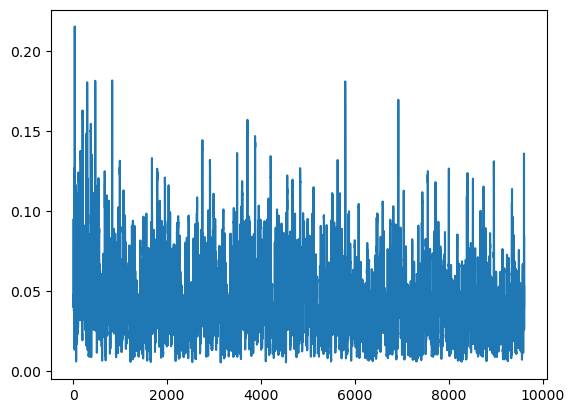

In [13]:
plt.plot(losses)

In [14]:
# torch.save(transition.state_dict(), './saved_models/10step_transition_3d.pth')

In [16]:
objective = nn.MSELoss()
losses = []
transition.eval()

for i, (X, y) in enumerate(testloader):
    X = X.to(torch.float32).to(device)
    n_steps = 1
    # n_steps = 1
    while (i) * testloader.batch_size + X.shape[0] + n_steps > len(testloader.dataset):
        n_steps -= 1
        print(n_steps)
        if n_steps == 1:
            continue # is this right?
        
    valid_steps = y > n_steps # make sure this is right?
    valid_steps = valid_steps.squeeze()
    
    
    z = enc(X[valid_steps.squeeze(),:,:])
    z.requires_grad_(True)
    next_z = transition(z, n_steps)
    xhat = dec(next_z)

    
    
    future_data = testloader.dataset[(i) * testloader.batch_size + n_steps : (i) * testloader.batch_size + X.shape[0] + n_steps][0]
    true_future = torch.tensor(future_data[valid_steps, -1, :]).to(torch.float32).to(device)
    loss = objective(xhat, true_future) # how do we get the data ahead in time?

    losses.append(loss.item())
    
print(f"Test 10 step loss: {np.mean(losses)}")

0
Test 10 step loss: 0.040691178349289495
